# Client Analysis
This notebook is ideal to understand schema and data within the databases storing in data

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json

### How many clients, workouts, and rows (session 10 second windows)?

In [2]:
# Connect to the database
conn = sqlite3.connect('../data/client_1_cardio.db')
conn_1 = sqlite3.connect('../data/client_2_cardio.db')
conn_2 = sqlite3.connect('../data/client_3_cardio.db')

In [3]:
# Read tables into DataFrames for all three clients
workouts_1 = pd.read_sql_query("SELECT * FROM cardio", conn)
sessions_1 = pd.read_sql_query("SELECT * FROM aggregated_cardio_session_data", conn)

workouts_2 = pd.read_sql_query("SELECT * FROM cardio", conn_1)
sessions_2 = pd.read_sql_query("SELECT * FROM aggregated_cardio_session_data", conn_1)

workouts_3 = pd.read_sql_query("SELECT * FROM cardio", conn_2)
sessions_3 = pd.read_sql_query("SELECT * FROM aggregated_cardio_session_data", conn_2)

# Close connections
conn.close()
conn_1.close()
conn_2.close()

print(f"Client 1: Loaded {len(workouts_1)} workouts, {len(sessions_1)} session rows")
print(f"Client 2: Loaded {len(workouts_2)} workouts, {len(sessions_2)} session rows")
print(f"Client 3: Loaded {len(workouts_3)} workouts, {len(sessions_3)} session rows")

Client 1: Loaded 3 workouts, 108 session rows
Client 2: Loaded 6 workouts, 264 session rows
Client 3: Loaded 10 workouts, 563 session rows


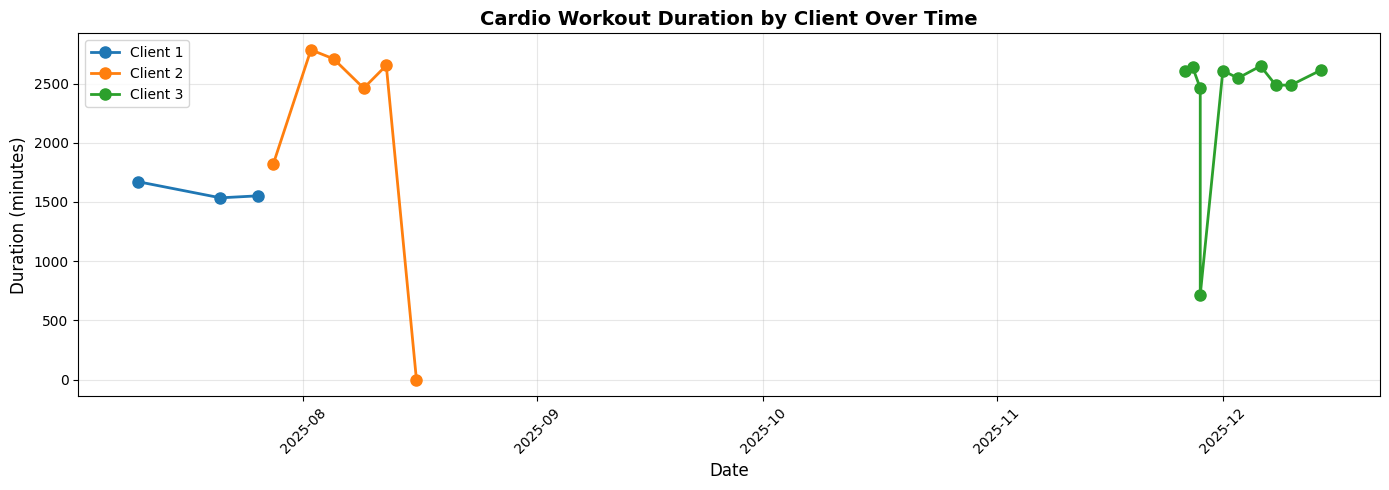

In [4]:
# Combine all workouts and add client identifier
workouts_1['client'] = 'Client 1'
workouts_2['client'] = 'Client 2'
workouts_3['client'] = 'Client 3'

all_workouts = pd.concat([workouts_1, workouts_2, workouts_3], ignore_index=True)

# Convert cardio_date to datetime
all_workouts['cardio_date'] = pd.to_datetime(all_workouts['cardio_date'])

# Sort by date
all_workouts = all_workouts.sort_values('cardio_date')

# Create the plot
plt.figure(figsize=(14, 5))

# Plot for each client
for client in ['Client 1', 'Client 2', 'Client 3']:
    client_data = all_workouts[all_workouts['client'] == client].sort_values('cardio_date')
    plt.plot(client_data['cardio_date'], client_data['duration'], 
             marker='o', label=client, linewidth=2, markersize=8)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.title('Cardio Workout Duration by Client Over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis

In [5]:
# Info
all_workouts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1 to 18
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 19 non-null     int64         
 1   cardio_name        19 non-null     object        
 2   cardio_type        19 non-null     object        
 3   duration           19 non-null     int64         
 4   distance           19 non-null     float64       
 5   avg_pace           19 non-null     float64       
 6   calories_burned    19 non-null     int64         
 7   notes              19 non-null     object        
 8   created_at         19 non-null     object        
 9   updated_at         19 non-null     object        
 10  client_id          19 non-null     int64         
 11  avg_speed          19 non-null     float64       
 12  avg_heart_rate     19 non-null     float64       
 13  cardio_date        19 non-null     datetime64[ns]
 14  cardio_end_time  

### Cardio Type

In [6]:
# Create a summary dataframe of cardio types per client
cardio_summary = pd.DataFrame({
    'Client 1': workouts_1['cardio_type'].value_counts(),
    'Client 2': workouts_2['cardio_type'].value_counts(),
    'Client 3': workouts_3['cardio_type'].value_counts()
}).fillna(0).astype(int)

print(cardio_summary)

             Client 1  Client 2  Client 3
cardio_type                              
Run                 3         6        10


### Major Questions

1. Volume & Consistency
- How many runs per week? Frequency progression?

2. Total Distance
- Progression

3. Pace Trends
- Is average pace improving, declining, or staying consistent over time?

4. Recovery
- Are there adequate rest days between runs, especially after long/hard efforts?

5. Injury/Worrying Signals
- Warning signs like declining performance, elevated heart rate at same pace, or mentions of pain in notes?


6. Environmental Factors
- How do elevation or time of day affect performance?


In [7]:
# Frequency Progression
# Convert cardio_date to datetime and extract week information
all_workouts['cardio_date'] = pd.to_datetime(all_workouts['cardio_date'])
all_workouts['week'] = all_workouts['cardio_date'].dt.isocalendar().week
all_workouts['year'] = all_workouts['cardio_date'].dt.year
all_workouts['year_week'] = all_workouts['year'].astype(str) + '-W' + all_workouts['week'].astype(str)

# Count workouts per week for each client
frequency_df = all_workouts.groupby(['client', 'year_week']).size().reset_index(name='workouts_per_week')
frequency_pivot = frequency_df.pivot(index='year_week', columns='client', values='workouts_per_week').fillna(0).astype(int)

print("Workout Frequency by Week:")
print(frequency_pivot)
print(f"\nAverage workouts per week:")
print(frequency_pivot.mean())

Workout Frequency by Week:
client     Client 1  Client 2  Client 3
year_week                              
2025-W28          1         0         0
2025-W30          2         0         0
2025-W31          0         2         0
2025-W32          0         2         0
2025-W33          0         2         0
2025-W48          0         0         4
2025-W49          0         0         3
2025-W50          0         0         3

Average workouts per week:
client
Client 1    0.375
Client 2    0.750
Client 3    1.250
dtype: float64


#### Distance is meters

In [8]:
### Distance Progression
# Calculate total distance per week for each client (convert meters to miles)
distance_df = all_workouts.groupby(['client', 'year_week'])['distance'].sum().reset_index(name='total_distance')
distance_df['total_distance'] = distance_df['total_distance'] / 1609.34  # Convert meters to miles

distance_pivot = distance_df.pivot(index='year_week', columns='client', values='total_distance').fillna(0).round(2)

print("Total Distance by Week (miles):")
print(distance_pivot)
print(f"\nAverage weekly distance (miles):")
print(distance_pivot.mean().round(2))
print(f"\nWeek-over-week change (miles):")
print(distance_pivot.diff().round(2))

Total Distance by Week (miles):
client     Client 1  Client 2  Client 3
year_week                              
2025-W28       2.32      0.00      0.00
2025-W30       5.96      0.00      0.00
2025-W31       0.00      8.11      0.00
2025-W32       0.00      9.72      0.00
2025-W33       0.00      4.74      0.00
2025-W48       0.00      0.00     16.47
2025-W49       0.00      0.00     13.08
2025-W50       0.00      0.00     15.00

Average weekly distance (miles):
client
Client 1    1.03
Client 2    2.82
Client 3    5.57
dtype: float64

Week-over-week change (miles):
client     Client 1  Client 2  Client 3
year_week                              
2025-W28        NaN       NaN       NaN
2025-W30       3.64      0.00      0.00
2025-W31      -5.96      8.11      0.00
2025-W32       0.00      1.61      0.00
2025-W33       0.00     -4.98      0.00
2025-W48       0.00     -4.74     16.47
2025-W49       0.00      0.00     -3.39
2025-W50       0.00      0.00      1.92


In [9]:
all_workouts['cardio_name'].unique()

array(['5K Run', '5 Mile Run', '1 Mile', 'Afternoon Run', 'Morning Run'],
      dtype=object)

### Client 3 pace is in sec/km metrics

In [10]:
### Pace Trends
# Convert ONLY Client 3 from sec/km to min/mile
# Step 1: sec/km to min/km (divide by 60)
# Step 2: min/km to min/mile (multiply by 1.60934)
all_workouts.loc[all_workouts['client'] == 'Client 3', 'avg_pace'] = (all_workouts.loc[all_workouts['client'] == 'Client 3', 'avg_pace'] / 60) * 1.60934

# Calculate average pace per week for each client
pace_df = all_workouts.groupby(['client', 'year_week'])['avg_pace'].mean().reset_index(name='avg_pace')
pace_pivot = pace_df.pivot(index='year_week', columns='client', values='avg_pace').fillna(0).round(2)

print("Average Pace by Week (min/mile):")
print(pace_pivot)
print(f"\nAverage pace across all weeks (min/mile):")
print(pace_pivot[pace_pivot > 0].mean().round(2))
print(f"\nWeek-over-week pace change (negative = faster):")
print(pace_pivot.diff().round(2))

Average Pace by Week (min/mile):
client     Client 1  Client 2  Client 3
year_week                              
2025-W28       7.79      0.00      0.00
2025-W30       8.85      0.00      0.00
2025-W31       0.00      7.08      0.00
2025-W32       0.00      9.69      0.00
2025-W33       0.00      5.27      0.00
2025-W48       0.00      0.00      8.90
2025-W49       0.00      0.00     10.51
2025-W50       0.00      0.00      8.43

Average pace across all weeks (min/mile):
client
Client 1    8.32
Client 2    7.35
Client 3    9.28
dtype: float64

Week-over-week pace change (negative = faster):
client     Client 1  Client 2  Client 3
year_week                              
2025-W28        NaN       NaN       NaN
2025-W30       1.06      0.00      0.00
2025-W31      -8.85      7.08      0.00
2025-W32       0.00      2.61      0.00
2025-W33       0.00     -4.42      0.00
2025-W48       0.00     -5.27      8.90
2025-W49       0.00      0.00      1.61
2025-W50       0.00      0.00     -2.08
